## Notebook instructions
This notebook contains modular analysis workflows for all gut electrophysiology data. Use the navigation menu in the sidebar to jump into the relevant section.

> **Note**: The plots and analysis routines are dataset-specific.  
> Be sure to set the appropriate configuration for:
> - `"stim_drugs"` datasets 
> - `"distension"` datasets 
> - `"other species"` datasets 

Datasets can be found in: https://doi.org/10.5281/zenodo.15162113 and https://doi.org/10.5281/zenodo.15162121

**ANALYSIS INSTRUCTIONS BY DATASET TYPE**

1. Drug stimulation traces
- Purpose: Analyze tissue responses to chemical stimuli (e.g., BK, capsaicin).
- Steps:
    0. Loading the relevant dataset and run the configuration cells
    1. Jump to: 'Filtering' - Apply tight bandpass filtering (300–2000 Hz) + notch filtering at 50 Hz and harmonics.
    2. Jump to: 'Plot extracted periods'
       - 'Configuration' - Define to extract 10 s before and 90 s after drug application.
       - 'Configuration' - Uncomment the dataset you are using, to retrieve the specific information
       - Run 'General plots' and ' Drug plots'. This will save also a cvs with the results of the AUC.
    3. Jump to: 'Analysis drug desensitization', which plots the boxplots and computes the statistical analysis between groups after multiple drugs additions.
       This section can be run in isolation

2. Contraction traces
- Purpose: Visualize signal changes during contractions events.
Note the contraction events are extracted from rat 1 and rat 2 stim drugs traces by selecting the appropriate windows in 'Plot extracted periods-Configuration'
- Steps:
    0. Loading the relevant dataset and run the configuration cells
    1. Jump to: 'Filtering' - Apply wide bandpass filtering (0–2000 Hz) and tight bandpass filtering (300–2000 Hz) + notch.
    2. Jump to: 'Plot extracted periods'
       - 'Configuration' - Define to extract 30 s before and 160 s after contraction onset.
       - 'Configuration' - Uncomment the dataset you are using, to retrieve the specific information
       - Run 'General plots' and 'Contraction visualisation' to plot envelopes of the signal

3. Distension traces
- Purpose: Compare responses to mechanical distension.
- Steps:
    0. Loading the relevant dataset and run the configuration cells
    1. Jump to: 'Filtering' - Apply low-pass filtering (cutoff at 300 Hz) and tight bandpass filtering (300–2000 Hz). No notch filter needed.
    2. Jump to: 'Plot extracted periods'
       - 'Configuration' - Define to extract 10 s post-distension windows.
       - 'Configuration' - Uncomment the dataset you are using, to retrieve the specific information
       - Run 'General plots' to compute AUC of positive signal and normalize AUC to [0–1] range across segments.
    3. Jump to: 'Group analysis mechanical distension', which plots the boxplots and computes the statistical analysis (Shapiro-Wilk for normality,
       Levene’s test for variance, t-test or Mann-Whitney U depending on assumptions) between groups.
       This section can be run in isolation

4. Stress-response multifrequency band analysis - chronic dataset
- Purpose: To gain insights into the contributions of various biological sources to the recorded signals in the context of stress response. 
- Steps:
    0. Loading the relevant dataset and run the configuration cells
    1. Jump to: 'Channel referencing' - Reference signals by subtracting the mean across selected channels to reduce shared artifacts.
    2. Jump to: 'Compute power in frequency bands'
       - Segmentation: Divide referenced signals into 1-minute intervals to track temporal evolution.
       - Apply bandpass filters to extract biologically relevant bands
       - Run cell to compute PSD for each channel and frequency band.
       - Run cell to normalize power by bandwidth to allow fair comparison across bands. The outcome will be normalized power per frequency range (μV²/Hz).
       - .csv files will be stored in a folder to be subsequently loaded with the script 'gut_chronic_plots' to visualise plots.


## Import libraries and run general functions

In [89]:
import IPython

%matplotlib ipympl

import os
import sys
import json
import time
import math
import datetime
import statistics
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.dates as md
from matplotlib import colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter

# Scipy
import scipy as sp
from scipy import signal
from scipy import ndimage
from scipy.signal import savgol_filter


In [90]:
# General functions
# Define a custom function to format the tick labels as empty strings
def hide_tick_labels(value, pos):
    return ""

# Exponential Moving Average (EMA) smoothing
def exponential_moving_average(data, alpha):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

def plot_freq_content(signal2plot, fs, ch, nperseg=512, max_freq=10000, ylim=None, dtformat='%M:%S.%f', figsize=(10, 15), savefigpath='', show=False, cmap='viridis',  colorbar_ticks=[], no_label=False):
    """
    plt.specgram parameters: 
    NFFT : int
        The number of data points used in each block for the FFT. A power 2 is most efficient. The default value is 256.
        The benefit of a longer FFT is that you will have more frequency resolution. The number of FFT bins, the discrete 
        fequency interval of the transform will be N/2. So the frequency resolution of each bin will be the sample frequency Fs x 2/N.
    mode : {'default', 'psd', 'magnitude', 'angle', 'phase'}
        What sort of spectrum to use. Default is 'psd', which takes the power spectral density. 
        'magnitude' returns the magnitude spectrum. 'angle' returns the phase spectrum without unwrapping. 
        'phase' returns the phase spectrum with unwrapping.
    scale : {'default', 'linear', 'dB'}
        The scaling of the values in the spec. 'linear' is no scaling. 'dB' returns the values in dB scale. When mode is 'psd', 
        this is dB power (10 * log10). Otherwise this is dB amplitude (20 * log10). 'default' is 'dB' if mode is 'psd' or 'magnitude' 
        and 'linear' otherwise. This must be 'linear' if mode is 'angle' or 'phase'.
    """
    # Raw signal
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    ax[0].plot(signal2plot.index, signal2plot['ch_%s'%ch], color='#aaa9a8', linewidth=0.5, zorder=0)
    ax[0].set_title('Sampling Frequency: {}Hz'.format(fs))
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Voltage [uV]')
    if ylim is not None:
        ax[0].set_ylim(ylim)

    # PSD (whole dataset ferquency distribution)
    f_data, Pxx_den_data = signal.welch(signal2plot['ch_%s'%ch], fs, nperseg=512) # nperseg
    # ax[1].psd(data[0:sf], NFFT=1024, Fs=sf)
    ax[1].semilogx(f_data, Pxx_den_data)
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel('PSD [V**2/Hz]')

    # Spectogram (frequency content vs time)
    plt.subplot(313)
    if len(colorbar_ticks)==0:
        powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(signal2plot['ch_%s'%ch], NFFT=nperseg, Fs=fs, mode='psd', scale='dB', cmap=cmap)
        # Extract vmin from powerSpectrum
        vmin = np.min(powerSpectrum)
        print(vmin)
        vmax = np.max(powerSpectrum)
        colorbar_ticks = [vmin, vmax]
    else:
        vmin=colorbar_ticks[0]
        vmax=colorbar_ticks[-1]
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(signal2plot['ch_%s'%ch], NFFT=nperseg, Fs=fs, mode='psd', scale='dB', cmap=cmap,  vmin=vmin, vmax=vmax)
    plt.ylabel('Spectogram \n Frequenct [Hz]')
    plt.xlabel('Time [s]')
    plt.ylim([0, max_freq])
    clb = plt.colorbar(imageAxis,ax=plt.gca(), ticks=colorbar_ticks, format='%.1f')
    clb.ax.set_title('10*np.log10 \n [dB/Hz]') 

    # Format axes
    for i in range(len(ax)):
        # Hide the right and top spines
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        # Only show ticks on the left and bottom spines
        ax[i].yaxis.set_ticks_position('left')
        ax[i].xaxis.set_ticks_position('bottom')
        if no_label:
            #ax[i].set_xticks([])
            #ax[i].set_yticks([])
            ax[i].set_ylabel('')
            ax[i].set_xlabel('')
    ax[0].xaxis.set_major_formatter(md.DateFormatter(dtformat))

    if savefigpath!='':
        plt.savefig(savefigpath, facecolor='w')

    if show==True:
        plt.show()
    else:
        print('Plot will not show')
        plt.close()


def filter(fs, signal2filt, filtername, channels, **kargs):
    """
    Apply filtering to selected channels in a DataFrame.

    Parameters:
    -----------
    fs : float
        Sampling frequency in Hz.
    signal2filt : pd.DataFrame
        DataFrame containing the signal to filter.
    filtername : str
        Type of filter to apply: 'None', 'butter', or 'notch'.
    channels : list
        List of column names (channels) to filter.
    **kargs : dict
        Additional arguments for the filter (e.g., Wn, N, btype for butter).

    Returns:
    --------
    pd.DataFrame
        Filtered DataFrame.
    """
    if filtername == 'None':
        print('No filter applied.')
        return signal2filt

    elif filtername == 'butter':
        print('Applying Butterworth filter with parameters:', kargs)
        kargs['fs'] = fs
        sos = signal.butter(**kargs, output='sos')
        filtered = signal2filt.copy()
        filtered[channels] = filtered[channels].apply(lambda x: signal.sosfilt(sos, x), axis=0)
        return filtered

    elif filtername == 'notch':
        print('Applying notch filter with parameters:', kargs)
        f0 = kargs.get('f0', 50)  # Default notch frequency
        Q = kargs.get('quality_factor', 30)
        b, a = signal.iirnotch(f0, Q, fs)
        filtered = signal2filt.copy()
        filtered[channels] = filtered[channels].apply(lambda x: signal.filtfilt(b, a, x), axis=0)
        return filtered

    else:
        raise ValueError(f"Unsupported filter type: {filtername}")

def apply_notch_filters(df, fs, channels, notch_freqs, quality_factor=30):
    """
    Apply sequential notch filters to specified channels in a DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        Input signal data.
    fs : float
        Sampling frequency in Hz.
    channels : list
        List of channel names to filter.
    notch_freqs : iterable
        Frequencies at which to apply notch filters.
    quality_factor : float
        Q-factor for the notch filter.

    Returns:
    --------
    pd.DataFrame
        Filtered DataFrame.
    """
    filtered = df.copy()
    for freq in notch_freqs:
        print(f"Applying notch filter at {freq} Hz")
        b, a = signal.iirnotch(freq, quality_factor, fs)
        filtered[channels] = filtered[channels].apply(lambda x: signal.filtfilt(b, a, x), axis=0)
    return filtered


## Load data

In [4]:
time_start_overall = time.time()

In [16]:
path = '../' # Add here the path where you want your outcomes to be stored
filepath = '../rat1_distension_230714_111548_112648_Port A.pkl'  # Add here the path to your file

## PKL load

In [65]:
# When using port A: channels=range(0,32,1) by default port B:range(32,64,1)
# Start and dur in samples
time_start = time.time()
load_from_file=True
downsample = 1          
start=1*60*10000                   
dur= None                
port = 'Port A' # Change based on the file name
if filepath.endswith('.parquet'):
    record = pd.read_parquet(filepath)
    record_file = record.recording
elif filepath.endswith('.pkl'):
    record_file = pd.read_pickle(filepath)

fs = 30000
    
print(record_file)

# Create directory to save figures
if not os.path.exists('%s/figures/' %(path)):
    os.makedirs('%s/figures/' %(path))
print("Time elapsed: {} seconds".format(time.time()-time_start)) 



                                      ch_1        ch_2        ch_3  \
time                                                                 
1970-01-01 00:00:00.000000000 -1105.064941  155.220001  474.434998   
1970-01-01 00:00:00.000100000 -1119.494995  152.880005  474.825012   
1970-01-01 00:00:00.000200000 -1105.260010  163.800003  482.429993   
1970-01-01 00:00:00.000300000 -1098.239990  151.710007  504.269989   
1970-01-01 00:00:00.000400000 -1094.339966  170.429993  485.160004   
...                                    ...         ...         ...   
1970-01-01 00:11:02.348366666   119.730003  114.855003   95.160004   
1970-01-01 00:11:02.348466666   120.315002  112.709999   96.135002   
1970-01-01 00:11:02.348566666   124.214996  114.660004   91.845001   
1970-01-01 00:11:02.348666666   109.199997  109.980003   92.625000   
1970-01-01 00:11:02.348766666   114.855003  109.199997   95.160004   

                                     ch_5        ch_6       ch_7        ch_10  \
time    

In [59]:
channels = ['ch_7']  # 
# D4-6: ch1
# D7: ch 10
#rat chronic 1: [0,1,6,7,8,10,15,16,18,23,24,25,26,27,28,29,30,31] 
#rat chronic 2:[9,10,12,13,18,25,26,27,28,29,30,31]   
#rat chronic 3: [0,1,8,10,11,25,27,28,29,30,31]
#rat chronic 4: [1,2,3,5,25,28,29,30,31]
# mouse_Distension: [1,4,5,6,8,10,11,18,19,23,24,25,26,27,29]
# pig drugs = [0,1, 4,5,7, 8,9,  23, 24, 25,26, 27]  4

In [20]:
# Get current time for saving (avoid overwriting)
now = datetime.datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

## Configuration

In [22]:
# Configure
record.num_rows = 1+ int(round(len(channels)/4))
record.num_columns = 4#
plot_ch = int(channels[0])               
save_figure = True

## START ANALYSIS                                             


### Plot raw signal

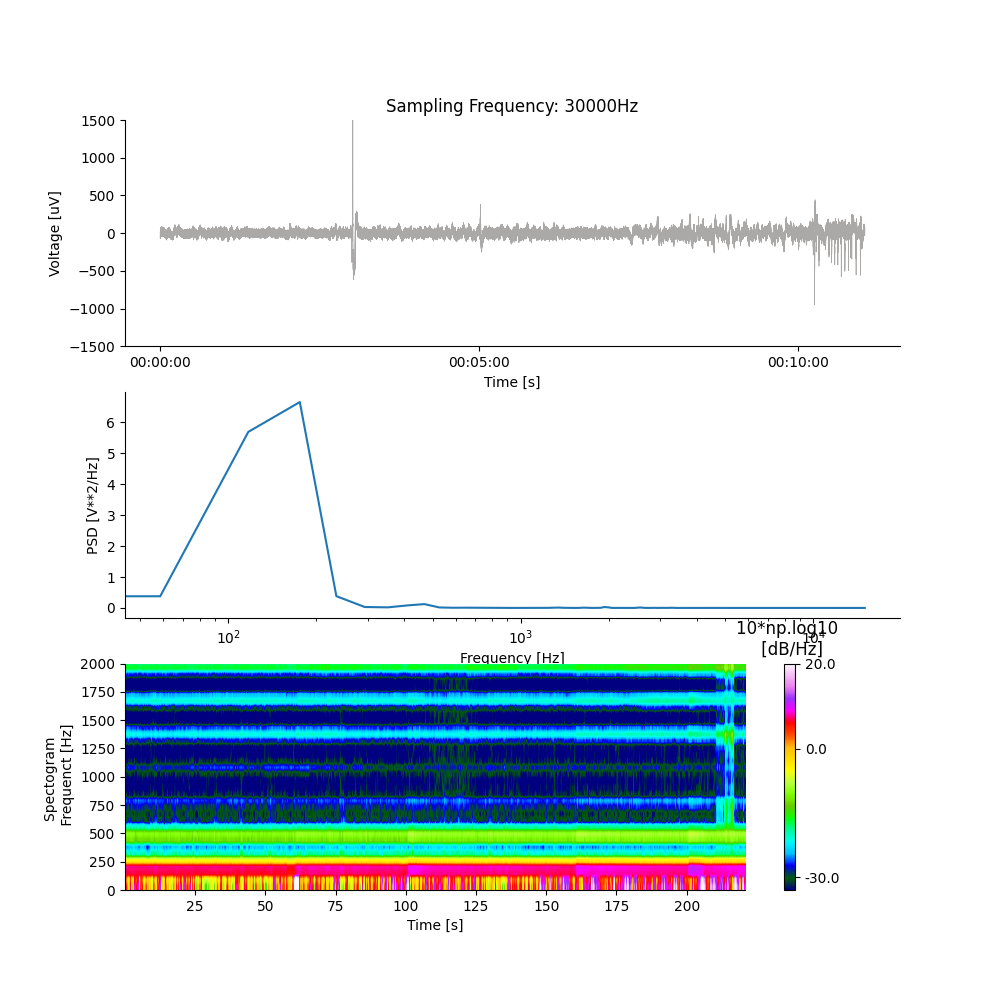

In [28]:
from matplotlib.colors import LinearSegmentedColormap

colorbar_ticks_raw=[20, 0, -30] 

cmap = 'gist_ncar' # 'nipy_spectral'

plot_freq_content(record_file,fs,int(plot_ch), nperseg=512, max_freq=2000, ylim=[-1500,1500], dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_original-%s.tiff' %(path, port, plot_ch, current_time), 
                         show=True,  cmap=cmap, colorbar_ticks=colorbar_ticks_raw) 

### Filtering

#### Bandwidth filter

##### Apply filter

In [81]:
filtered_df = filter(
    fs=fs,
    signal2filt=record_file,
    filtername='butter',
    channels=channels,
    N=9,
    Wn=[300], 
    btype='lowpass'
)
# [300, 2000]

Applying Butterworth filter with parameters: {'N': 9, 'Wn': [300], 'btype': 'lowpass'}


##### Plot filtered signal

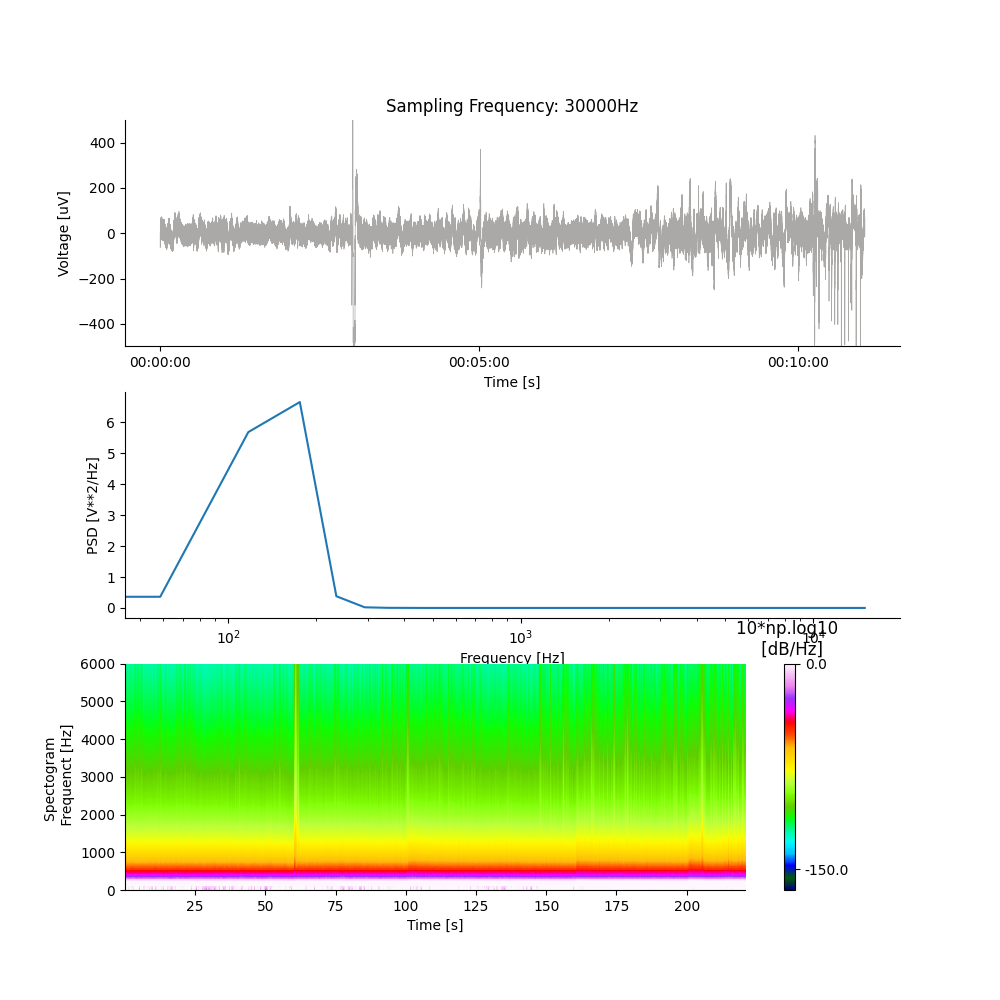

SystemExit: 

C:\Users\ampar\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [82]:
no_label = False

current_time = now.strftime("%d%m%Y_%H%M%S")
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

cmap = 'gist_ncar' # 'nipy_spectral'

freq_max = 6000 
textf = 'HF'
colorbar_ticks_filt= [0, -150]
nperseg=512

text_label = 'Filtered'
text = 'Channels after filtering'

plot_freq_content(filtered_df,fs, int(plot_ch), nperseg=nperseg, max_freq=freq_max, ylim=[-500,500], dtformat='%H:%M:%S', #ex vivo =[-0.5,0.5] In vivo: -120,120
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_%s_lab%s-%s.svg' %(path,port,plot_ch, textf, no_label, current_time),
                         show=True, cmap=cmap, colorbar_ticks=colorbar_ticks_filt, no_label=no_label) 

#### Notch filtering

In [ ]:
# For drug recordings only
# Define odd harmonics of 50 Hz up to 2000 Hz
notch_freqs = range(50, 2000, 100)  # 50, 150, 250, ..., 1950

# Apply the notch filters
filtered_df = apply_notch_filters(record_file, fs, channels, notch_freqs)


#### Plot filtered signal

In [ ]:

ylim = [-400, 400]
no_label = False

text_label = 'Filtered'
text = 'Channels after %s filtering'%'notch'
colorbar_ticks= [50, -45] #[0, -50] #[15, 0, -50, -100, -150, -200] # [-20, -50]

no_label = False
cmap = 'gist_ncar' # 'nipy_spectral'
nperseg = 512
freq_max = 2000

plot_freq_content(filtered_df, fs, int(plot_ch), ylim=ylim, nperseg=nperseg, max_freq=freq_max, dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_allfilt_lab%s-%s.svg' %(path, port,plot_ch,no_label, current_time), 
                         show=True, cmap=cmap, colorbar_ticks=colorbar_ticks, no_label=no_label)  


### Plot extrated periods

#### Configuration

In [83]:
ch = channels[0]
seconds_bef = 0 # 10 # drugs: 10  contraction: 30seg  distension: 0  chronic:0 
seconds_after = 10 # 91    # drugs: 91   contraction: 160s  distension: 10  chronic:60  drugs_pig: 91
seconds = '%s-%s'%(seconds_bef,seconds_after) #'10-91s'
signal2plot= ''#'smoothed'


# if 'lowpass' filter use:
# freq_max = 100

freq_max =2000  
no_label = False

# Step 1: Define the multiple time points you want to use as references. 
# Uncomment the timepoints, labels and colours for the dataset you're using
#-----------------------------------------------------------------------------------------------------

# DISTENSION datasets 
#--------------------

# Rat 1 Distension 
time_points =  pd.to_datetime(['1970-01-01 00:03:00', '1970-01-01 00:05:00',  '1970-01-01 00:08:00', '1970-01-01 00:10:00']) #'1970-01-01 00:06:00',
labels = ['Dist', 'Dist', 'Dist', 'Dist'] #'Iso5%'

# Rat 2 Distension 
#time_points =  pd.to_datetime(['1970-01-01 00:06:00', '1970-01-01 00:07:00', '1970-01-01 00:08:00', '1970-01-01 00:10:00', '1970-01-01 00:12:00']) 
#labels = ['Dist', 'Dist', 'Iso5%', 'Dist', 'Dist']
#iso 5 5: no iso
#time_points =  pd.to_datetime(['1970-01-01 00:06:00', '1970-01-01 00:07:00', '1970-01-01 00:10:00', '1970-01-01 00:12:00']) 
#labels = ['Dist', 'Dist', 'Dist', 'Dist']

# Rat 3 Distension 
#time_points =  pd.to_datetime(['1970-01-01 00:03:00', '1970-01-01 00:05:00', '1970-01-01 00:08:00', '1970-01-01 00:10:00', '1970-01-01 00:15:45'])  # '1970-01-01 00:06:00', '1970-01-01 00:10:26', '1970-01-01 00:15:45'
#labels = ['Dist', 'Dist',  'Dist', 'Dist', 'Dist'] # 'Iso5%','Iso1%', 'Dist'
#colors = ['darkblue', 'cornflowerblue', 'darkred', 'indianred', 'cornflowerblue']

# Rat 4 Distension
#time_points =  pd.to_datetime(['1970-01-01 00:04:30', '1970-01-01 00:06:30',  '1970-01-01 00:11:30', '1970-01-01 00:13:30']) 
#time_points =  pd.to_datetime(['1970-01-01 00:04:30', '1970-01-01 00:06:30', '1970-01-01 00:07:30', '1970-01-01 00:11:30', '1970-01-01 00:13:30'])
#labels =  ['Dist', 'Dist', 'Dist', 'Dist'] # ['Dist', 'Dist', 'Iso5%', 'Dist', 'Dist']
#color_list = ['#700a97',  '#fe5803', 'darkred',  '#1a1aeb'] #'#a000c6', '#0044fb',

# Rat 5 Distension 
#time_points =  pd.to_datetime(['1970-01-01 00:01:10','1970-01-01 00:04:00', '1970-01-01 00:04:25', '1970-01-01 00:07:09', '1970-01-01 00:10:00']) 
#labels = ['Pre', 'Nif+Atr-base', 'Bath',  'Ligate', 'Nif+Atr'] # 
#colors = ['black', 'darkblue', 'green', 'black', 'chocolate']

#  Rat 6 Distension 
#time_points =  pd.to_datetime(['1970-01-01 00:02:00', '1970-01-01 00:07:30', '1970-01-01 00:08:30', '1970-01-01 00:12:30', '1970-01-01 00:13:00','1970-01-01 00:14:00']) 
#labels = ['Contraction?','Nif+Atr-base', 'Bath',  'Ligate', 'Nif+Atr', 'Release'] # 
#colors = ['green','darkblue', 'green', 'black', 'chocolate', 'black']

# Rat 7 Distension 
#time_points =  pd.to_datetime(['1970-01-01 00:05:24', '1970-01-01 00:05:30', '1970-01-01 00:08:00', '1970-01-01 00:11:00', '1970-01-01 00:12:30']) 
#labels = ['Nif+Atr-base', 'Bath',  'Ligate', 'Nif+Atr', 'Release'] # 
#colors = ['darkblue', 'green', 'black', 'chocolate', 'black']

# Rat 8 Distension 
#time_points =  pd.to_datetime(['1970-01-01 00:04:20','1970-01-01 00:05:00', '1970-01-01 00:05:28', '1970-01-01 00:07:00', '1970-01-01 00:10:00']) 
#labels = ['Nif+Atr-base', 'Clean', 'Bath',  'Ligate', 'Nif+Atr'] # 
#colors = ['darkblue', 'black', 'green', 'black', 'chocolate']

#-------------------------------------------------------------------

# DRUG SRIMULATION datasets 
#--------------------
# Rat 1 Stim Drugs 
#time_points =  pd.to_datetime(['1970-01-01 00:01:10','1970-01-01 00:03:05','1970-01-01 00:06:00','1970-01-01 00:08:30','1970-01-01 00:10:00', '1970-01-01 00:12:00', '1970-01-01 00:15:04', '1970-01-01 00:17:00', '1970-01-01 00:19:02', '1970-01-01 00:22:00', '1970-01-01 00:24:00', '1970-01-01 00:26:00', '1970-01-01 00:28:00', '1970-01-01 00:30:00', '1970-01-01 00:32:00', '1970-01-01 00:34:00', '1970-01-01 00:36:00', '1970-01-01 00:39:00', '1970-01-01 00:41:07', '1970-01-01 00:43:30'])
#labels = ['Wash','ASP', 'contraction', 'Wash', 'BK', 'BK2', 'Wash', 'Wash', 'BK3', 'BK4', 'Wash', 'BK5','Wash', 'Wash', 'BK6', 'Wash', 'Wash', 'Capsaicin serosa', 'Capsaicin injection', 'Capsaicin injection3']
#colors = ['black','darkblue', 'black','black','black','darkred', 'indianred', 'black','black','darkred','indianred', 'black','darkred','black','black', 'darkred','black','black', 'blue', 'blue', 'blue']

#time_points =  pd.to_datetime(['1970-01-01 00:10:03', '1970-01-01 00:12:04', '1970-01-01 00:19:05', '1970-01-01 00:22:00', '1970-01-01 00:26:04', '1970-01-01 00:32:00', ])
#labels = ['BK', 'BK2',  'BK3', 'BK4', 'BK5', 'BK6']

#time_points =  pd.to_datetime(['1970-01-01 00:01:07','1970-01-01 00:10:03', '1970-01-01 00:39:03', '1970-01-01 00:43:33'])
#labels = ['Wash', 'BK', 'Capsaicin serosa', 'Capsaicin injection']

#time_points =  pd.to_datetime(['1970-01-01 00:06:00'])
#labels = ['Contraction']

# Rat 2 Stim Drugs 
#time_points =  pd.to_datetime(['1970-01-01 00:10:00', '1970-01-01 00:11:00', '1970-01-01 00:15:00', '1970-01-01 00:17:00', '1970-01-01 00:20:30', '1970-01-01 00:21:30', '1970-01-01 00:24:04', '1970-01-01 00:27:00', '1970-01-01 00:29:40', '1970-01-01 00:31:00', '1970-01-01 00:34:00', '1970-01-01 00:36:00', '1970-01-01 00:38:00', '1970-01-01 00:43:00', '1970-01-01 00:45:04'])
#labels = ['ASP1', 'ASP2', 'Wash', 'BK', 'Wash', 'Wash', 'BK', 'Wash', 'Wash', 'BK', 'BK','Wash', 'Wash', 'Capsaicin srosa', 'Capsaicin injection']
#colors = ['darkblue', 'cornflowerblue', 'black', 'darkred', 'black','black','darkred', 'black','black','darkred','indianred', 'black','black', 'blue', 'blue']

#time_points =  pd.to_datetime([  '1970-01-01 00:23:00', '1970-01-01 00:38:00',  '1970-01-01 00:45:02', '1970-01-01 00:47:00']) #1970-01-01 00:24:04'
#labels = [ 'BK', 'Wash','Capsaicin serosa', 'Capsaicin injection']

#time_points =  pd.to_datetime(['1970-01-01 00:26:00']) #, '1970-01-01 00:35:00'])
#labels = ['Contraction1'] #, 'Contraction2']

# Rat 3 Stim Drugs 
#time_points =  pd.to_datetime(['1970-01-01 00:02:00', '1970-01-01 00:10:00', '1970-01-01 00:11:00', '1970-01-01 00:12:00', '1970-01-01 00:14:00', '1970-01-01 00:16:02', '1970-01-01 00:17:30',  '1970-01-01 00:19:10', '1970-01-01 00:22:00', '1970-01-01 00:25:10', '1970-01-01 00:27:06', '1970-01-01 00:31:18', '1970-01-01 00:34:10', '1970-01-01 00:38:40', '1970-01-01 00:44:00', '1970-01-01 00:46:05', '1970-01-01 00:48:00'])
#labels = ['iso 1%','ASP', 'ASP2', 'Wash', 'BK', 'BK2', 'Wash', 'Wash', 'BK3', 'Wash', 'Wash', 'BK4','Wash', 'Wash', 'BK5', 'Wash', 'Wash', 'Capsaicin serosa','Capsaicin serosa2', 'Capsaicin injection', 'Capsaicin injection3']

#time_points =  pd.to_datetime(['1970-01-01 00:10:00', '1970-01-01 00:11:00', '1970-01-01 00:12:00', '1970-01-01 00:14:00', '1970-01-01 00:16:02', '1970-01-01 00:17:30',  '1970-01-01 00:19:10', '1970-01-01 00:22:00', '1970-01-01 00:25:10', '1970-01-01 00:27:06', '1970-01-01 00:31:18', '1970-01-01 00:34:10', '1970-01-01 00:38:40', '1970-01-01 00:44:00', '1970-01-01 00:46:05', '1970-01-01 00:48:00'])
#labels = ['ASP', 'ASP2', 'Wash', 'BK', 'BK2', 'Wash', 'Wash', 'BK3', 'Wash', 'Wash', 'BK4','Wash', 'Wash', 'Capsaicin serosa','Capsaicin serosa2', 'Capsaicin injection', 'Capsaicin injection3']
#color_list = ['darkblue', 'cornflowerblue', 'black', 'darkred','indianred', 'black','black','darkred', 'black','black','darkred', 'black','black','blue', 'blue', 'blue']

#time_points =  pd.to_datetime([ '1970-01-01 00:12:23', '1970-01-01 00:22:00', '1970-01-01 00:46:05', '1970-01-01 00:48:00']) #  '1970-01-01 00:22:00', '1970-01-01 00:46:05' , '1970-01-01 00:14:00',  '1970-01-01 00:44:02',
#labels = ['Wash', 'BK', 'Capsaicin serosa', 'Capsaicin injection', ]

'''
# Rat 4 Stim Drugs 
time_points =  pd.to_datetime(['1970-01-01 00:10:00', '1970-01-01 00:12:00', '1970-01-01 00:15:00', '1970-01-01 00:17:00', '1970-01-01 00:17:30',
                                '1970-01-01 00:20:00', '1970-01-01 00:22:00', '1970-01-01 00:25:00', '1970-01-01 00:25:30', '1970-01-01 00:27:00', 
                                '1970-01-01 00:29:00', '1970-01-01 00:32:00', '1970-01-01 00:34:00', '1970-01-01 00:34:30', '1970-01-01 00:36:00',
                                '1970-01-01 00:39:00', '1970-01-01 00:39:30', '1970-01-01 00:41:00', '1970-01-01 00:41:30', '1970-01-01 00:43:00', '1970-01-01 00:45:00'])
labels = ['BK', 'BK2', 'Wash', 'Wash', 'clean',
            'BK3', 'BK4', 'Wash', 'clean','Wash',  
            'BK5','Wash', 'Wash', 'clean','BK6', 
            'Wash','clean', 'Wash', 'dry', 'Capsaicin serosa', 'Capsaicin injection']
colors = ['darkred', 'indianred', 'black','black','black',
            'darkred','indianred', 'black','black','black',
            'darkred','black','black','black', 'darkred',
            'black','black', 'black','black', 'blue', 'blue']
'''
'''
# Rat 5 Stim Drugs 
time_points =  pd.to_datetime(['1970-01-01 00:10:00', '1970-01-01 00:12:00', '1970-01-01 00:15:00', '1970-01-01 00:17:00', '1970-01-01 00:17:30',
                                '1970-01-01 00:20:00', '1970-01-01 00:22:00', '1970-01-01 00:25:00', '1970-01-01 00:25:30', '1970-01-01 00:27:00', 
                                '1970-01-01 00:29:00', '1970-01-01 00:32:00', '1970-01-01 00:34:00', '1970-01-01 00:34:30', '1970-01-01 00:36:00',
                                '1970-01-01 00:39:00', '1970-01-01 00:39:30', '1970-01-01 00:41:00', '1970-01-01 00:41:30', '1970-01-01 00:43:00', '1970-01-01 00:45:00'])
labels = ['BK', 'BK2', 'Wash', 'Wash', 'clean',
            'BK3', 'BK4', 'Wash', 'clean','Wash',  
            'BK5','Wash', 'Wash', 'clean','BK6', 
            'Wash','clean', 'Wash', 'dry', 'Capsaicin serosa', 'Capsaicin injection']
colors = ['darkred', 'indianred', 'black','black','black',
            'darkred','indianred', 'black','black','black',
            'darkred','black','black','black', 'darkred',
            'black','black', 'black','black', 'blue', 'blue']
'''
'''
# Rat 6 Stim Drugs 
time_points =  pd.to_datetime(['1970-01-01 00:11:00', '1970-01-01 00:13:00', '1970-01-01 00:15:00', '1970-01-01 00:17:00', '1970-01-01 00:20:00', '1970-01-01 00:22:00', '1970-01-01 00:22:30',
                               '1970-01-01 00:25:00', '1970-01-01 00:27:00', '1970-01-01 00:30:00', '1970-01-01 00:30:30', '1970-01-01 00:32:00', 
                                '1970-01-01 00:34:00', '1970-01-01 00:37:00', '1970-01-01 00:39:00', '1970-01-01 00:39:30', '1970-01-01 00:41:00',
                                '1970-01-01 00:44:00', '1970-01-01 00:44:30', '1970-01-01 00:46:00', '1970-01-01 00:46:30', '1970-01-01 00:49:00', '1970-01-01 00:50:00'])
labels = ['BK','wash', 'BK1', 'BK2', 'Wash', 'Wash', 'clean',
            'BK3', 'BK4', 'Wash', 'clean','Wash',  
            'BK5','Wash', 'Wash', 'clean','BK6', 
            'Wash','clean', 'Wash', 'dry', 'Capsaicin serosa', 'Capsaicin injection']
colors = ['darkred','black','darkred', 'indianred', 'black','black','black',
            'darkred','indianred', 'black','black','black',
            'darkred','black','black','black', 'darkred',
            'black','black', 'black','black', 'blue', 'blue']
'''
#-------------------------------------------------------------------

## Chronic recordings
#--------------------
# Day 1 
# Chronic_Gut_Rat2A_Rat3B_Day-1_231024_124851_baseline
#time_points =  pd.to_datetime(['1970-01-01 00:00:00','1970-01-01 00:05:00'])
#labels = ['base_1', 'base_2']
#colors = ['cornflowerblue', 'cornflowerblue']

# Chronic_Gut_Rat2A_Day-1_231024_132052_baseline+eat 
#time_points =  pd.to_datetime(['1970-01-01 00:01:30','1970-01-01 00:03:00', '1970-01-01 00:05:45']) #, '1970-01-01 00:07:23'])
#labels = ['clean_pre_1', 'clean_pre_2','clean_during'] #,'noise_after_eat']
#colors = ['cornflowerblue', 'cornflowerblue', 'green'] #, 'indianred']

# Chronic_Gut_Rat2A_Day-1_231024_133626_15 min after eat
#time_points =  pd.to_datetime(['1970-01-01 00:00:00','1970-01-01 00:02:00', '1970-01-01 00:05:30', '1970-01-01 00:07:00'])
#labels = ['post_1', 'post_2','post_3', 'post_4']
#colors = ['purple', 'indianred', 'indianred', 'indianred']

#Chronic_Gut_Rat2A_Day-1_231024_134645_eat again
#time_points =  pd.to_datetime(['1970-01-01 00:00:50','1970-01-01 00:03:30','1970-01-01 00:05:00','1970-01-01 00:10:00','1970-01-01 00:11:00', '1970-01-01 00:20:00', '1970-01-01 00:30:00', '1970-01-01 00:32:00'])
#labels = ['grooming','still','pre_1', 'pre_2', 'during', 'post_2', 'post_3','post_4']
#colors = ['black','purple','cornflowerblue', 'cornflowerblue', 'green', 'indianred', 'indianred','indianred','indianred']

'''
# Day 7
# Chronic_Gut_Rat2A_Day-7_231030_124826_good eat
time_points =  pd.to_datetime(['1970-01-01 00:06:41','1970-01-01 00:14:00', '1970-01-01 00:15:00','1970-01-01 00:20:20']) #, '1970-01-01 00:07:23'])
labels = ['clean_pre_1', 'clean_pre_2','clean_pre_3','clean_during'] #,'noise_after_eat']
colors = ['cornflowerblue', 'cornflowerblue','cornflowerblue', 'green'] #, 'indianred']
'''
'''
# Chronic_Gut_Rat2A_Day-7_231030_132351_after eat
time_points =  pd.to_datetime(['1970-01-01 00:01:30','1970-01-01 00:03:10']) 
labels = ['post_1', 'post_2']
colors = ['indianred', 'indianred'] 
'''
'''
# Chronic_Gut_Rat2A_Day-7_231030_132921_after eat
time_points =  pd.to_datetime(['1970-01-01 00:07:30','1970-01-01 00:09:00','1970-01-01 00:10:30','1970-01-01 00:12:00']) 
labels = ['post_1', 'post_2','post_3', 'post_4']
colors = ['indianred', 'indianred','indianred','indianred'] 
'''

# Day 14
'''
# Chronic_Gut_Rat2A_Day-14_231106_122309_baseline
time_points =  pd.to_datetime(['1970-01-01 00:09:56','1970-01-01 00:11:00'])
labels = ['base_1', 'base_2'] 
colors = ['cornflowerblue', 'cornflowerblue']

#Chronic_Gut_Rat2A_Day-14_231106_125501_baseline
time_points =  pd.to_datetime(['1970-01-01 00:00:25','1970-01-01 00:02:50', '1970-01-01 00:04:20'])
labels = ['base_1', 'base_2','base_3'] 
colors = ['cornflowerblue', 'cornflowerblue','cornflowerblue']
'''
#----------------------------------------------------------------------------------------------------------

# Ex vivo 
#-----------------------
# bk 12-10-23
#time_points =  pd.to_datetime(['1970-01-01 00:08:30','1970-01-01 01:23:00'])
#labels = ['BK1', 'Bk2'] 
#colors = ['darkred', 'darkred']

#----------------------------------------------------------------------------------------------------------

# Other species
#-----------------
#Mouse:  it's 2% to 1.5% at 2min, distension at 5min, then 1.5% to 5% iso at 6min with another distension at 8min
#time_points =  pd.to_datetime(['1970-01-01 00:02:00', '1970-01-01 00:05:00', '1970-01-01 00:6:00', '1970-01-01 00:8:00']) 
#labels = ['2->1.5%', 'Dist', '5%', 'Dist']
#colors = ['black','darkblue','black', 'darkred']

# Pig distension
#time_points =  pd.to_datetime(['1970-01-01 00:00:00','1970-01-01 00:01:00', '1970-01-01 00:02:00', '1970-01-01 00:03:00', '1970-01-01 00:04:00', '1970-01-01 00:05:00', '1970-01-01 00:06:00', '1970-01-01 00:07:00', '1970-01-01 00:08:00']) 
#labels = ['base', 'Tension', 'base', 'torsion','base','Tension', 'base', 'torsion','base']
#colors = ['black','purple','black', 'pink', 'black','purple','black', 'pink', 'black']

# Pig drugs
#time_points =  pd.to_datetime(['1970-01-01 00:00:10','1970-01-01 00:02:00', '1970-01-01 00:12:00', '1970-01-01 00:13:00', '1970-01-01 00:14:00', '1970-01-01 00:24:00']) 
#labels = ['Base', 'BK', 'Saline', 'Base', 'Caps', 'Saline' ]
#colors = ['black','darkblue','green', 'black', 'darkred', 'green']
#time_points =  pd.to_datetime(['1970-01-01 00:00:10','1970-01-01 00:02:00', '1970-01-01 00:14:00']) 
#labels = ['Baseline (2min)','BK (at 2min)', 'Caps (at 14min)' ]
#colors = ['black','darkblue','darkred']
#----------------------------------------------------------------------------------------------------------

# original colors  # uncomment for silencing and drugs unless especifically listed below the set
colors = ['darkblue', 'cornflowerblue', 'darkred', 'indianred'] # SILENCING/DRUGS

# Define Savitzky-Golay filter parameters
window_size = 800
order = 2

# Create a list to store the extracted periods
extracted_periods = []
extracted_periods_raw = []

# Loop through each time point and extract the corresponding period
for time_point in time_points:
    # Use boolean indexing to extract the period that matches the time point
    period = filtered_df.loc[time_point- pd.Timedelta(seconds=seconds_bef) :time_point+ pd.Timedelta(seconds=seconds_after)]
    extracted_periods.append(period)        


#### General plots

In [84]:
no_label = False

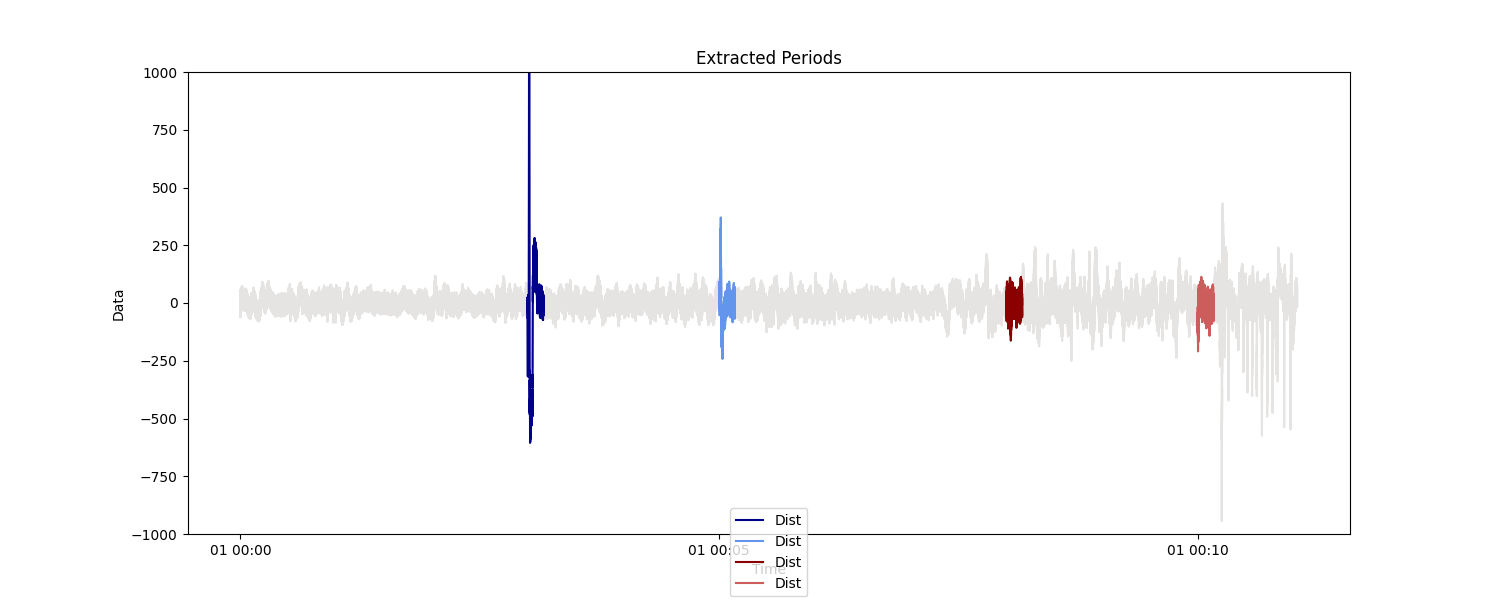

In [85]:
#-------------------------------------------------------------
# PLOT 1: Plot the extracted periods using the time index (to underlying signal)
plt.figure(figsize=(15, 6))
plt.plot(filtered_df.index,filtered_df[ch], '#E5E4E2')
for i, period in enumerate(extracted_periods):
    plt.plot(period.index, period[ch], label=labels[i], color=colors[i]) #f"Period {i+1}")
plt.ylim([-1000,1000])
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Extracted Periods')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15))
#no_label = False
if no_label:
    # Get the current axes (equivalent to ax)
    ax = plt.gca()
    # Set the custom formatter for both the x-axis and y-axis
    ax.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
    ax.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
    plt.legend('')
    

plt.savefig('%s/figures/_ylim_Fig1_%s_ch%s_extracted-locs-%sseg-%s_%s.tiff' %(path,port,ch, seconds,current_time, no_label), facecolor='w')


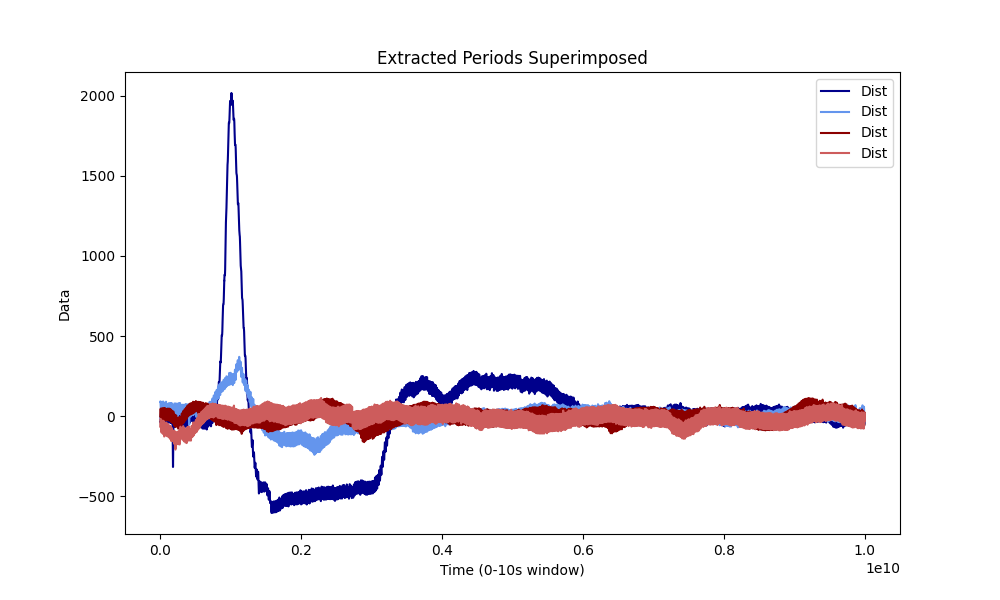

In [86]:
#-------------------------------------------------------------
# PLOT 2: Plot all extracted periods superimposed 
lines = []
plt.figure(figsize=(10, 6))
for i, period in enumerate(extracted_periods):
    if signal2plot == 'smoothed':
        # Apply Savitzky-Golay filter for smoothing
        smoothed_data = savgol_filter(period[ch], window_size, order)
        line, = plt.plot(period.index - period.index.min(), smoothed_data, label=labels[i], color=colors[i]) #f"Period {i+1}")
    else:
        line, = plt.plot(period.index - period.index.min(), period[ch], label=labels[i], color=colors[i]) #f"Period {i+1}")
    lines.append(line)
    
plt.xlabel('Time (%ss window)'%seconds)
plt.ylabel('Data')
plt.title('Extracted Periods Superimposed')
plt.legend()
if no_label:
    # Get the current axes (equivalent to ax)
    ax = plt.gca()
    # Set the custom formatter for both the x-axis and y-axis
    ax.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
    ax.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
    
plt.show()
if signal2plot == 'smoothed':
    plt.savefig('%s/figures/Fig2_%s_ch%s_superimposed-extracted-smoothed-%s.png' %(path, port,ch, current_time), facecolor='w')
else:
    plt.savefig('%s/figures/Fig2-%s_ch%s_superimposed-extracted-%sseg-%s_%s.tiff' %(path, port,ch, seconds, current_time, no_label), facecolor='w')

# Get the colors and y-axis limits from the superimposed figure
colors = [line.get_color() for line in lines]
y_min, y_max = plt.gca().get_ylim()


[180007200000 180007300000 180007400000 ... 189999800000 189999900000
 190000000000]
[ 0.46419927  1.35355513  2.23419993 ...  9.3378442   9.98670111
 10.61006071]
[300000033333 300000133333 300000233333 ... 309992866666 309992966666
 309993066666]
[88.33118812 88.7916963  89.22101401 ...  4.65135497  3.01972119
  1.39466723]
[480000233333 480000333333 480000433333 ... 489999766666 489999866666
 489999966666]
[ 0.0330367   1.24642936  2.46886266 ... 19.16951368 19.42287229
 19.63523332]
[600543833333 600543933333 600544033333 ... 609997633333 609997733333
 609997833333]
[0.60803141 1.65115429 2.65752602 ... 3.0037563  1.72548331 0.41809984]
Normalise Area under the curve for positive values (normalised): [1.         0.11848246 0.01302828 0.        ]
 Area under the curve for positive values (AUC-minus min): [8.13304797e+11 9.63623503e+10 1.05959633e+10 0.00000000e+00]
 ABsolute area under the curve for positive values (AUC): [968985600454.6918, 252043153843.1688, 166276766834.7597, 155

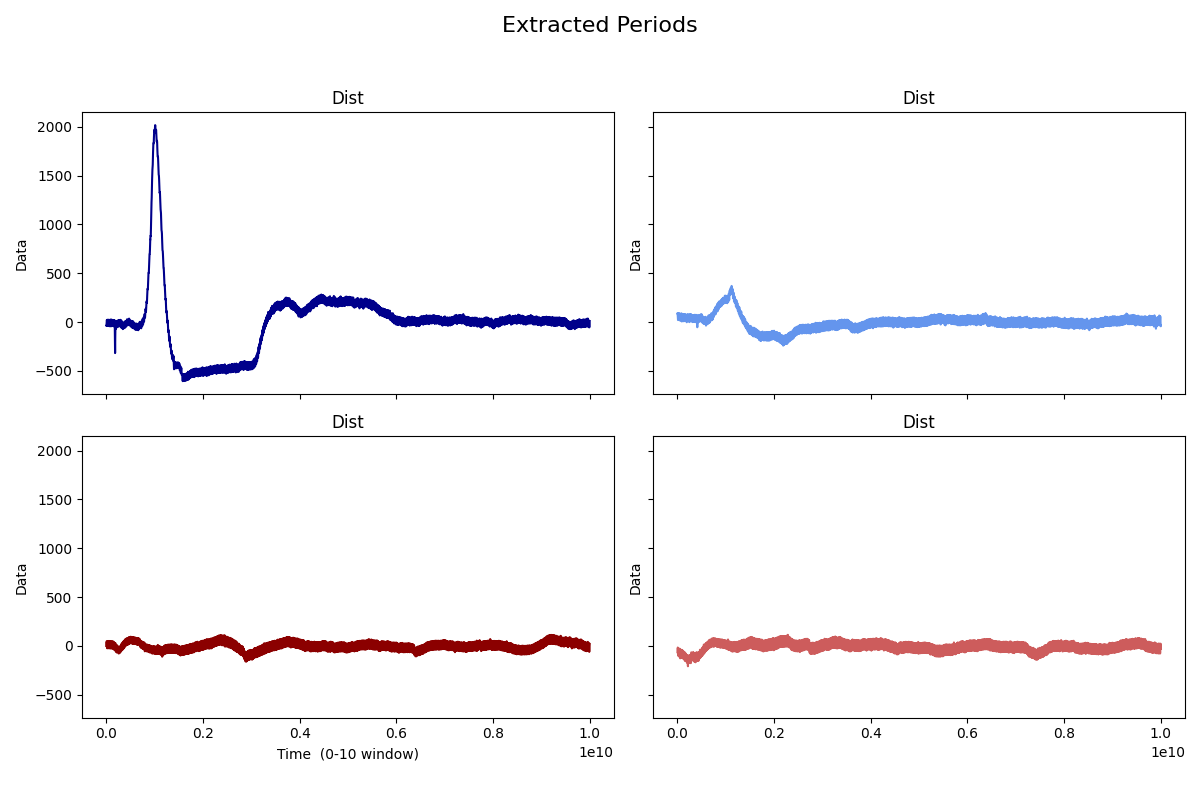

SystemExit: 

C:\Users\ampar\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [87]:
# PLOT 3: Plot each extracted period in different rows
#'''
#no_label = True
zoom = False
# Calculate the number of rows and columns for the grid
num_signals = len(extracted_periods)
num_cols = int(math.ceil(math.sqrt(num_signals)))
num_rows = int(math.ceil(num_signals / num_cols))

# Plot each extracted period in a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle('Extracted Periods', fontsize=16)

auc = []
maxim = []
rang = []

for i, (period, ax, color) in enumerate(zip(extracted_periods, axs.flatten(),colors)):
    ax.plot(period.index - period.index.min(), period[ch],color=color, label=labels[i]) #'grey'
    ax.set_ylabel('Data')
    ax.set_title(labels[i])
    if zoom:
        ax.set_ylim(-2500, 2500) # 2500 Low freque, 200 high freq
    else:
        ax.set_ylim(y_min, y_max)
    if no_label:
        # Set the custom formatter for both the x-axis and y-axis
        ax.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
    
    ####### Extract AUC
    # Filter the DataFrame to include only rows with positive y-values
    positive_period = period[ch][period[ch] > 0]
    #print(positive_period)

    # Calculate the area under the curve using the trapezoidal rule
    #x_values = positive_period.index
    # Calculate the time difference in hours for each row
    x_values = (positive_period.index- pd.Timestamp("1970-01-01")) // pd.Timedelta(nanoseconds=1)
    print(x_values.values)
    y_values = positive_period.values
    print(y_values)
    area_under_curve = np.trapz(y_values, x=x_values.values)
    auc.append(area_under_curve)

    ### Extract max and range
    max_val = period[ch].max()
    maxim.append(max_val)
    range_val = period[ch].max() - period[ch].min()
    rang.append(range_val)
    
print("Normalise Area under the curve for positive values (normalised):", (auc-min(auc))/(max(auc)-min(auc)))
print(" Area under the curve for positive values (AUC-minus min):", (auc-min(auc)))
print(" ABsolute area under the curve for positive values (AUC):", (auc))
print(" Max:", (maxim))
print(" Range:", (rang))

# Remove any empty subplots
for i in range(num_signals, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

axs[num_rows - 1, 0].set_xlabel('Time  (%s window)'%seconds)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('%s/figures/Fig3-%s_%s_ch%s_-extracted-%s_%s.tiff' %(path, port,zoom,ch, current_time, no_label), facecolor='w')
plt.show()



#### Contraction visualisation 

In [ ]:
# PLOT for contraction visualisation
from scipy.signal import hilbert, chirp
# Function to extract the envelope of a signal
def extract_envelope(signal):
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

current_time = now.strftime("%d%m%Y_%H%M%S")
cmap = 'gist_ncar'

# Define Savitzky-Golay filter parameters
window_size = int(fs)
order = 2

lines = []
signal_ch = [7,15]
no_label = False
print(signal_ch)
num_signals = len(signal_ch)
num_cols = int(math.ceil(math.sqrt(num_signals)))
num_rows = int(math.ceil(num_signals / num_cols))
print(num_cols)
print(num_rows)

signal2plot = 'envelop' # 'envelop'

# Initialize a list to store smoothed envelopes
smoothed_envelopes = []

# Create the subplots grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8), sharex=True, sharey=True)
fig.suptitle('Spectrogram filtered signal', fontsize=16)
fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(8, 8), sharex=True, sharey=True)
fig3, axs3 = plt.subplots(figsize=(8, 8), sharex=True, sharey=True)
period = extracted_periods[0]
#print(period)

for i,ch,ax,ax2 in zip(range(0,len(signal_ch),1),signal_ch, axs.flat, axs2.flat):
    if signal2plot == 'smoothed':
        # Apply Savitzky-Golay filter for smoothing
        smoothed_data = savgol_filter(period['ch_%s'%ch], window_size, order)
        line, = ax2.plot(period.index - period.index.min(), smoothed_data, label='ch: %s'%ch) #, color=colors[i]) #f"Period {i+1}")
    elif signal2plot == 'envelop':
        sp = 'env'
        envelope = extract_envelope(period['ch_%s'%ch])
        #smoothed_env = savgol_filter(envelop, window_size, order)
        smoothed_env = np.convolve(envelope, np.ones(window_size)/window_size, mode='same')
        smoothed_envelopes.append(smoothed_env)  # Store the smoothed envelope in the list

        line, = ax2.plot(period.index - period.index.min(), smoothed_env, label='ch: %s'%ch, color='grey') #, color=colors[i]) #f"Period {i+1}")
        ax2.set_ylim([0, 4]) #[-40,40])
    else:
        sp = 's'
        line, = ax2.plot(period.index - period.index.min(), period['ch_%s'%ch], label='ch: %s'%ch, color='grey') #f"Period {i+1}")
        line, = axs3.plot(period.index - period.index.min(), period['ch_%s'%ch], label='ch: %s'%ch, color='grey') #f"Period {i+1}")
        ax2.set_ylim([-40, 40]) #[-40,40])
    
    # PLOT the spectrogram and store the returned imageAxis
    powerSpectrum, freqenciesFound, times_spec, imageAxis = ax.specgram(period['ch_%s' % ch], NFFT=512*8, Fs=fs, mode='psd', scale='dB', cmap=cmap) # colorbar_ticks=colorbar_ticks_filt)
    
    ax.set_ylabel('ch: %s'%ch)
    ax.set_xlabel('Time [s]')
    # Adjust frequency limits based on your data characteristics
    ax.set_ylim([0, filt_config['W'][1]]) #[filt_config['W'][0]
    if no_label:
        # Set the custom formatter for both the x-axis and y-axis
        ax.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax2.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax2.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs3.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs3.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.set_ylabel('')
        ax.set_xlabel('')
    
    # Adjust the color scale normalization to highlight changes
    norm = plt.Normalize(vmin=-40, vmax = 20) #colorbar_ticks_filt[-1], vmax=colorbar_ticks_filt[0]) # 0, -60 -40,20
    imageAxis.set_norm(norm)
    # Create a colorbar associated with the current subplot
    clb = plt.colorbar(imageAxis, ax=ax)
    clb.ax.set_title('10*np.log10 \n [dB/Hz]')
    
# Calculate the standard deviation of the smoothed envelopes
if smoothed_envelopes:
    average_envelope = np.mean(smoothed_envelopes, axis=0)
    plt.figure()
    # Plot the average smoothed envelope
    line, = plt.plot(period.index - period.index.min(), average_envelope, label='Average Envelope', color='grey')
    plt.ylim([0, 4]) #[-40,40])
    plt.savefig('%s/figures/Contraction_%s_%s_average_%s_%s_ch%s-%sseg-%s.svg' %(path, sp,filt_config['W'], no_label, port,ch, seconds, current_time), facecolor='w')

plt.xlabel('Time (%ss window)'%seconds)
plt.ylabel('Data')
fig2.suptitle('Extracted Periods')
plt.legend()

In [ ]:
plt.savefig('%s/figures/Contraction_%s_%s_average_%s_%s_ch%s-%sseg-%s.svg' %(path, sp,filt_config['W'], no_label, port,ch, seconds, current_time), facecolor='w')


#### Drug plots

In [ ]:
#-------------------------------------------------------------
# PLOT 5:  Plot array of filtered spectrograms - drug recordings
# PLOT 6:  Rolling AUC - drug recordings
# PLOT 7:  Plot array of PSD filtered signal 
#---------------------------------------------------------
from scipy import integrate #import simps  # For numerical integration
cmap = 'gist_ncar' # 'nipy_spectral'

no_label = False
#Calculate the number of rows and columns for the grid
num_signals = len(extracted_periods)
#num_cols = int(math.ceil(math.sqrt(num_signals)))
#num_rows = int(math.ceil(num_signals / num_cols))
num_cols = 2  # Set the number of columns to 4
num_rows = int(math.ceil(num_signals / num_cols))
colorbar_ticks = [0, -60]
times = [4, 30, 50, 99] #sec within spectrum to extract PSD
nperseg = 512

leng = 2603 # from max number of samples

# Create the subplots grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 8), sharex=True) #, sharey=True)
fig.suptitle('Spectrogram filtered signal', fontsize=16)

fig2, axs2 = plt.subplots(1, len(labels), figsize=(16, 4), sharex=True, sharey=True) #len(times)
fig2.suptitle('Drugs PSD at specific times %s' %times, fontsize=16)
fig3, axs3 = plt.subplots(len(labels), 1, figsize=(8, 4), sharex=True, sharey=True)
fig3.suptitle('Area under the curve in a rolling window', fontsize=16)
#fig4, axs4 = plt.subplots(1, len(times), figsize=(12, 4), sharex=True, sharey=True)
#fig4.suptitle('Caps Inj PSD at specific times', fontsize=16)

# Define the rolling window size and step size (adjust as needed)
window_size = int(1*leng/(seconds_after+seconds_bef))  # Number of columns (time steps) in the rolling window
print(window_size)
step_size = 1   # Number of columns to shift the window each time

# Create an empty DataFrame to store the AUC values in separate columns
AUC_roll = pd.DataFrame()
    
# Iterate through the extracted_periods and axs
for period, ax, ax3, label in zip(extracted_periods, axs.flat, axs3.flat, labels):
    x_seconds = (period.index - period.index.min()).total_seconds()
    
    # PLOT the spectrogram and store the returned imageAxis
    powerSpectrum, freqenciesFound, times_spec, imageAxis = ax.specgram(period['ch_%s' % ch], NFFT=nperseg, Fs=fs, mode='psd', scale='dB', cmap=cmap) # colorbar_ticks=colorbar_ticks_filt)

    # -----------------------
    # Initialize an empty list to store the area under the curve for each window
    areas = []

    # Iterate through the powerSpectrum columns with the rolling window
    for i in range(0, powerSpectrum.shape[1] - window_size + 1, step_size):
        
        window = powerSpectrum[:, i:i+window_size]  # Extract the window
        frequency_axis = freqenciesFound  # Replace with your actual frequency axis
        # Compute the area under the curve using numerical integration
        area = np.mean(integrate.simpson(abs(window), dx=(frequency_axis[1] - frequency_axis[0]), axis=0))
        #print('----')
        #print(area)
        areas.append(area)
        #print(areas)

    # Create a new column with a unique name for each iteration and store the area values
    #column_name = label  # Create a unique column name
    AUC_roll['%s'%label] = areas
    
    print('------------%s-------)'%label)
    AUC_roll_max = AUC_roll['%s'%label].iloc[int(15*leng/(seconds_after+seconds_bef)):int(60*leng/(seconds_after+seconds_bef))]#-1]    # To second 60 for BK recording, for all responses put back -1
    print('AUC_max_value & value: %s & %s' %(np.argmax(AUC_roll_max), np.max(AUC_roll_max)))
    print('mean_value: %s' %(np.mean(AUC_roll_max)))
    print('var_value: %s' %(np.var(AUC_roll_max)))
    
    #sys.exit()
    # PLOT the cumulative area under the curve
    ax3.plot(np.linspace(0, int(len(areas)*(seconds_after+seconds_bef)/leng),len(areas)), areas)
    ax3.set_ylim(0, 100) #00)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('AUC')
    
    if no_label:
        # Set the custom formatter for both the x-axis and y-axis
        ax3.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax3.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax3.set_title('')
    
    fig3.savefig('%s/figures/Fig6_%s_%s_ch%s_-AUC-%sseg-%s.tiff' %(path, no_label, port,ch, seconds, current_time), facecolor='w')
    fig3.savefig('%s/figures/Fig6_%s_%s_ch%s_-AUC-%sseg-%s.svg' %(path, no_label, port,ch, seconds, current_time), facecolor='w')
    # -----------------------
    
    # Get the size of each dimension
    rows, columns = powerSpectrum.shape
    
    # Compute sample corresponding the each time point from times and total number of samples. OJO moved to below on 26th Nov (after running all images) to make it autmatic using columns
    samples = [int(t*columns/(seconds_after+seconds_bef)) for t in times] #times for PSD plots  257 (if nperseg=512)/ 129 if nperseg=256 coresponds to time 130s, make proportion
    print(samples)
    
    # PLOT PSD at each time point
    if label == 'contraction':
        axs2[0].plot(freqenciesFound, powerSpectrum[:,samples[0]])
        axs2[1].plot(freqenciesFound, powerSpectrum[:,column_with_max_value])
        axs2[2].plot(freqenciesFound, powerSpectrum[:,samples[-1]])
        axs2[0].set_xscale('log')   
        
        fig2.savefig('%s/figures/Fig7_%s_ch%s_-PSD_filtered-%sseg-%s.tiff' %(path, port,ch, seconds, current_time), facecolor='w')
        fig2.savefig('%s/figures/Fig7_%s_ch%s_-PSD_filtered-%sseg-%s.svg' %(path, port,ch, seconds, current_time), facecolor='w')

        
    if label == 'BK':      
        axs2[0].plot(freqenciesFound, powerSpectrum[:,samples[0]], label='%s'%times[0], color='tan')
        axs2[0].plot(freqenciesFound, powerSpectrum[:,samples[1]], label='%s'%times[1], color='darkolivegreen') # column_with_max_value
        axs2[0].plot(freqenciesFound, powerSpectrum[:,samples[2]],label='%s'%times[2], color='yellowgreen')
        axs2[0].plot(freqenciesFound, powerSpectrum[:,samples[3]],label='%s'%times[3], color='lightgreen')
        axs2[0].set_xscale('log')   
        axs2[0].legend()
        axs2[0].set_ylabel('BK - PSD dB') #10*np.log10(Pxx) = 
        
    if label == 'Capsaicin serosa':        
        axs2[1].plot(freqenciesFound, powerSpectrum[:,samples[0]], label='%s'%times[0], color='tan')
        axs2[1].plot(freqenciesFound, powerSpectrum[:,samples[1]], label='%s'%times[1], color='darkolivegreen') # column_with_max_value
        axs2[1].plot(freqenciesFound, powerSpectrum[:,samples[2]],label='%s'%times[2], color='yellowgreen')
        axs2[1].plot(freqenciesFound, powerSpectrum[:,samples[3]],label='%s'%times[3], color='lightgreen')
        axs2[1].set_xscale('log')   
        axs2[1].legend()
        axs2[1].set_ylabel('CAP S - PSD dB') #10*np.log10(Pxx) = 

    
    if label == 'Capsaicin injection':
        axs2[2].plot(freqenciesFound, powerSpectrum[:,samples[0]], label='%s'%times[0], color='tan')
        axs2[2].plot(freqenciesFound, powerSpectrum[:,samples[1]], label='%s'%times[1], color='darkolivegreen') # column_with_max_value
        axs2[2].plot(freqenciesFound, powerSpectrum[:,samples[2]],label='%s'%times[2], color='yellowgreen')
        axs2[2].plot(freqenciesFound, powerSpectrum[:,samples[3]],label='%s'%times[3], color='lightgreen')
        axs2[2].set_xscale('log')  
        #axs2[2].set_yscale('log')  
        axs2[2].legend()
        axs2[2].set_ylabel('CAP I - PSD dB') #10*np.log10(Pxx) = 
        axs2[2].set_ylim([0,0.045]) #10
        axs2[2].set_xlim([200,2000])

    if label == 'Wash':
        axs2[3].plot(freqenciesFound, powerSpectrum[:,samples[0]], label='%s'%times[0], color='tan')
        axs2[3].plot(freqenciesFound, powerSpectrum[:,samples[1]], label='%s'%times[1], color='darkolivegreen') # column_with_max_value
        axs2[3].plot(freqenciesFound, powerSpectrum[:,samples[2]],label='%s'%times[2], color='yellowgreen')
        axs2[3].plot(freqenciesFound, powerSpectrum[:,samples[3]],label='%s'%times[3], color='lightgreen')
        axs2[3].set_xscale('log')  
        axs2[3].legend()
        axs2[3].set_ylabel(' Saline - PSD dB') #10*np.log10(Pxx) = 


    if no_label:
        # Set the custom formatter for both the x-axis and y-axis
        axs2[0].xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs2[0].yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs2[1].xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs2[1].yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs2[2].xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs2[2].yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs2[3].xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        axs2[3].yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        #axs2.set_title('')
    fig2.savefig('%s/figures/Fig7_%s_%s_ch%s_-PSD_filtered-%sseg-%s.png' %(path, no_label, port,ch, seconds, current_time), facecolor='w')
    fig2.savefig('%s/figures/Fig7_%s_%s_ch%s_-PSD_filtered-%sseg-%s.svg' %(path,no_label,  port,ch, seconds, current_time), facecolor='w')
    
    # Adjust the color scale normalization to highlight changes
    norm = plt.Normalize(vmin=-50, vmax = -10) #vmax = 20 for round 2 drugs #colorbar_ticks_filt[-1], vmax=colorbar_ticks_filt[0]) # 0, -60
    imageAxis.set_norm(norm)
    
    ax.set_ylabel(label)
    ax.set_xlabel('Time [s]')
    # Adjust frequency limits based on your data characteristics
    ax.set_ylim([0, freq_max])
    
    if no_label:
        # Set the custom formatter for both the x-axis and y-axis
        ax.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.set_title('')
    
    # Create a colorbar associated with the current subplot
    clb = plt.colorbar(imageAxis, ax=ax)
    clb.ax.set_title('10*np.log10 \n [dB/Hz]')
    #clb.set_ticks(colorbar_ticks_filt)  # Adjust the ticks for the colorbar
    
fig.savefig('%s/figures/Fig5_%s_%s_ch%s_-spectrogram_filtered-%sseg-%s.tiff' %(path, no_label, port,ch, seconds, current_time), facecolor='w')
fig.savefig('%s/figures/Fig5_%s_%s_ch%s_-spectrogram_filtered-%sseg-%s.svg' %(path, no_label, port,ch, seconds, current_time), facecolor='w')

# Save the DataFrame to a CSV file in the specified folder
AUC_roll.to_csv('%s/AUC_roll_%s.csv'%(path, filt_config['W']), index=False)  # Set index=False to exclude the index column

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


sys.exit()

### Group analysis mechanical distension

In [ ]:
## BOXPLOTS of all AUC mechanical distension recordings
path = dir_name + ''

data_norm = {
    'Dist1': [1, 1, 1, 0.06],
    'Dist2': [0.79, 0.11, 0.68, 1],
    'Dist3': [0.68, 0.01, 0.23, 0.03],
    'Dist4': [0, 0, 0, 0]
}

data = {
    'Dist1': [3.42E+11, 8.15E+11, 1.50E+11, 6.10E+10],
    'Dist2': [2.68E+11, 9.69E+10, 1.01E+11, 9.88E+11],
    'Dist3': [2.33E+11, 1.18E+10, 3.48E+10, 3.59E+10],
    'Dist4': [0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00]
}

data_norm_mean ={
    'Dist_pre_mean': [0.895, 0.555, 0.84, 0.53],
    'Dist_post_mean': [0.34, 0.005, 0.115, 0.015],
}
data_mean = {
    'Dist_pre_mean': [3.05188E+11, 4.55872E+11, 1.25411E+11, 5.24589E+11],
    'Dist_post_mean': [1.16323E+11, 5878040550, 17384168950, 17974769550],
}

no_label = False

datasets = [data_norm, data, data_norm_mean, data_mean]
dataset_name = ['data_norm', 'data-min', 'data_norm_mean', 'data_mean']

datasets_mean = [data_norm_mean, data_mean]
dataset_name_mean = ['data_norm_mean', 'data_mean']
colors_mean = [colors[1], colors[3]]

# Create a figure and axis
fig1, axs = plt.subplots(1,2,figsize=(10, 4))

for ax, data, name in zip(axs.flatten(), datasets, dataset_name):
    df = pd.DataFrame(data)
    sns.set(style="whitegrid")  # Optional: Customize the style

    # Boxplot
    sns.boxplot(data=df, ax=ax, showfliers=True, palette=colors)  # Set showfliers to True if you want to display outliers

    # Dots
    sns.stripplot(data=df,ax=ax, color='black', size=8, jitter=True, alpha=0.7)
    if no_label:
        # Set the custom formatter for both the x-axis and y-axis
        ax.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.set_title('')
        
# Create a figure and axis
fig2, axs = plt.subplots(1,2,figsize=(10, 4))

for ax, data, name in zip(axs.flatten(), datasets_mean, dataset_name_mean):
    df = pd.DataFrame(data)
    sns.set(style="whitegrid")  # Optional: Customize the style

    # Boxplot
    sns.boxplot(data=df, ax=ax, showfliers=True, palette=colors_mean)  # Set showfliers to True if you want to display outliers

    # Dots
    sns.stripplot(data=df,ax=ax, color='black', size=8, jitter=True, alpha=0.7)

    if no_label:
        # Set the custom formatter for both the x-axis and y-axis
        ax.xaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.yaxis.set_major_formatter(FuncFormatter(hide_tick_labels))
        ax.set_title('')
        
#plt.title('Boxplot with Individual Dots for Silencing Groups')

fig1.savefig('%s/distension/AUC_all_comparison_%s.svg' %(path, no_label), facecolor='w')
fig2.savefig('%s/distension/AUC_pre-post_comparison_%s.svg' %(path, no_label), facecolor='w')
plt.show()

In [ ]:
# Distension stst test
distpre = [1, 1, 1, 0.06, 0.79, 0.11, 0.68, 1]
distpost = [0.68, 0.01, 0.23, 0.03, 0, 0, 0, 0]

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(distpre, distpost)

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Determine the significance level (alpha)
alpha = 0.05

# Compare p-value to alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the means.")

### Analysis drug desensitization 

This section plots the boxplots metrics reporting AUC for each addition group, and compute statistical analysis
The data here has been combined manually based on the AUC extracted from the 'Drug plots' section

In [ ]:
# BK evolution - desensitization expanded to all datasets (round 2)
data = {
    'Dataset1': [
        [1,  0.7325,     0.5725,       0.0525],  # Max
        [1,  0.81372549, 0.5,          0.029411765],  # Mean
        [1,  0.977900552, 0.812154696, 0.011049724],  # Var
    ],
    'Dataset2': [ #DR3
    [0.792149099, 0, 0.002111918, 0.001364807],  # Max 
    [0.791443167, 0, 0.002256279, 0.001532567],  # Mean
    [0.629132665, 0, 4.8667e-06, 2.10015e-06],  # Var 
    ],
    'Dataset3': [
    [1,  0.00754394,   0.091809181, 0],  # Max
    [1,  0.008122801,  0.090693956, 0],  # Mean 
    [1,  5.97107e-05, 0.00846952, 0],  # Var 
    ],
    'Dataset4': [
    [1,  0.807011901, 0.222257961, 0.240913477],  # Max 
    [1,  0.676056338, 0.225352113, 0.154929577],  # Mean
    [1,  0.66457529,  0.055501931, 0.065637066]]  # Var 
}
data = data

# BK groups
bk_groups = ['BK1', 'BK2', 'BK3', 'BK4'] #

# Convert the data into the desired structure
result = {}
for dataset_name, values in data.items():
    result[dataset_name] = {
        bk: {'Max': values[0][i], 'Mean': values[1][i], 'Var': values[2][i]}
        for i, bk in enumerate(bk_groups)
    }

# Extract metrics across all datasets
metrics = ['Max', 'Mean', 'Var']

# Prepare storage for mean and std calculations
metric_data = {metric: {bk: [] for bk in bk_groups} for metric in metrics}

# Populate the storage
for dataset in result.values():
    for bk in bk_groups:
        for metric in metrics:
            metric_data[metric][bk].append(dataset[bk][metric])

# Calculate mean and std for each metric across BK groups
metric_means = {metric: [] for metric in metrics}
metric_stds = {metric: [] for metric in metrics}

for metric in metrics:
    for bk in bk_groups:
        metric_means[metric].append(np.mean(metric_data[metric][bk]))
        metric_stds[metric].append(np.std(metric_data[metric][bk]))

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
colors = sns.color_palette('flare', len(bk_groups))

for i, metric in enumerate(metrics):
    # Create the bar plot
    axs[i].bar(bk_groups, metric_means[metric], color=colors, alpha=0.7, label='Mean')
    
    # Prepare data for swarmplot
    # Flatten data into a DataFrame
    df = pd.DataFrame({
        'BK': np.repeat(bk_groups, len(data)),
        'Metric Value': np.concatenate([metric_data[metric][bk] for bk in bk_groups]),
        'Metric': metric,
        'Dataset': np.tile(list(data.keys()), len(bk_groups))
    })
    
    # Use swarmplot with the correct data
    sns.swarmplot(x='BK', y='Metric Value', data=df, ax=axs[i], color='black', size=8, label='Data Points')

    # Asymmetric error bars: no lower error, only upper std deviation
    lower_error = np.zeros_like(metric_stds[metric])
    upper_error = metric_stds[metric]
    axs[i].errorbar(bk_groups, metric_means[metric], yerr=[lower_error, upper_error], fmt='none', 
                    ecolor='black', capsize=5, label='Upper Std Dev')
    
    axs[i].set_title(f'{metric} Mean + Upper Std Dev across Datasets')
    axs[i].set_ylabel(f'{metric}')
    axs[i].set_xlabel('BK Groups')
    axs[i].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

fig.savefig(f'{path}/BK_desensitization_all_{no_label}.svg', facecolor='w')


In [ ]:
from scipy.stats import levene, kruskal, mannwhitneyu

# Perform Levene's test for homogeneity of variances across BK groups
levene_results = {}
for metric in metrics:
    # Collect data from all groups for the current metric
    groups = [metric_data[metric][bk] for bk in bk_groups]
    
    # Apply Levene's test
    stat, p_value = levene(*groups)
    levene_results[metric] = (stat, p_value)
    
    # Interpret the results
    print(f"Levene's Test for {metric}:")
    print(f"Test Statistic = {stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"Result: Variances across BK groups are significantly different for {metric} (p < 0.05), suggesting non-homogeneity of variances.")
    else:
        print(f"Result: No significant difference in variances across BK groups for {metric} (p >= 0.05), suggesting homogeneity of variances.")
    print("\n")
    
# Perform appropriate non-parametric tests based on Levene's test results
for metric in metrics:
    print(f"Non-Parametric Tests for {metric}:")

    if levene_results[metric][1] >= 0.05:
        # Homogeneity of variances holds: Use Kruskal-Wallis test
        groups = [metric_data[metric][bk] for bk in bk_groups]
        stat, p_value = kruskal(*groups)
        print(f"Kruskal-Wallis Test: H-statistic = {stat:.4f}, p-value = {p_value:.4f}")
        
        if p_value < 0.05:
            print("Result: Significant difference between at least one pair of groups (p < 0.05).")
        else:
            print("Result: No significant difference between groups (p >= 0.05).")
        
    else:
        # Non-homogeneity of variances: Use pairwise Mann-Whitney U tests
        for i in range(len(bk_groups)):
            for j in range(i + 1, len(bk_groups)):
                group1 = metric_data[metric][bk_groups[i]]
                group2 = metric_data[metric][bk_groups[j]]
                stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                print(f"Mann-Whitney U Test {bk_groups[i]} vs {bk_groups[j]}: U-statistic = {stat}, p-value = {p_value:.4f}")
    
    print("\n")

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro, levene

# Right now only takes the last dataset, i.e. variance

# Perform t-tests between each pair of columns
columns = df.columns

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]

        # Normality test
        normal1 = shapiro(df[col1])[1] > 0.05
        normal2 = shapiro(df[col2])[1] > 0.05
        
        # Homogeneity of variance test (Levene's test)
        var_test = levene(df[col1], df[col2])[1] > 0.05
        
        if var_test:
            print("The variances are homogeneous.")
        else:
            print("The variances are not homogeneous.")
        
        if normal1 and normal2 and var_test:  # Proceed with t-test if both are normally distributed and homogeneous variance
            t_stat, p_value = ttest_ind(df[col1], df[col2])
            test_type = "t-test"
        else:
            t_stat, p_value = mannwhitneyu(df[col1], df[col2])
            test_type = "Mann-Whitney U test"

        print(f"{test_type} between {col1} and {col2}:")
        print(f"Statistic: {t_stat}, p-value: {p_value}")
        
        if p_value < 0.05:
            print("The difference is statistically significant.")
        else:
            print("The difference is not statistically significant.")
        
        
        print()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data_max_300 = {
    'Norm_wash': [0, 0, 0, 0, 0, 0.2842],
    'Norm_BK': [0.596385542, 0.333333333, 0.355555556, 1, 1, 1],
    'norm_capS': [0.486445783, 1, 0.024603175, 0.01189, 0.02083, 0],
    'norm_capI': [1, 1, 1, 0.002244, 0.001408, 0.228773]
}

data_mean_300 = {
    'Norm_wash': [0, 0.190283401, 0, 0, 0, 0.525],
    'Norm_BK': [0.466424082, 0, 0.467158672, 1, 1, 1],
    'norm_capS': [0.489579888, 0.939271255, 0.039483395, 0.0197, 0.02207, 0],
    'norm_capI': [1, 1, 1, 0.003174, 0.036144, 0.2875],
}

data_var_300 = {
    'Norm_wash': [0, 0, 0, 0, 0, 0.0718],
    'Norm_BK': [0.33, 0.075, 0.2, 1, 1, 1],
    'norm_capS': [0.21, 1, 0.0025, 0.000187, 0.00047, 0],
    'norm_capI': [0.998, 1, 1, 0.0000537, 0.000042, 0.0574]
}

datasets = {'Max': data_max_300, 'Mean': data_mean_300, 'Var': data_var_300}
conditions = ['Norm_wash', 'Norm_BK', 'norm_capS', 'norm_capI']

# Prepare data for plotting
plot_data = []

for metric, data in datasets.items():
    df = pd.DataFrame(data)
    df['Metric'] = metric
    df = df.reset_index().melt(id_vars=['Metric'], var_name='Condition', value_name='Value')
    plot_data.append(df)

plot_df = pd.concat(plot_data)

# Create a figure and axis
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

# Plot each condition
for idx, condition in enumerate(conditions):
    ax = axs[idx]
    condition_data = plot_df[plot_df['Condition'] == condition]
    
    # Check if condition_data is empty
    if condition_data.empty:
        continue
    
    sns.barplot(x='Metric', y='Value', hue='Metric', data=condition_data, ax=ax, palette='viridis')
    sns.swarmplot(x='Metric', y='Value', data=condition_data, ax=ax, color='black', size=8, alpha=0.7)
    
    ax.set_title(condition)
    ax.set_xlabel('Metric')
    ax.set_ylabel('Normalized Values')

# Adjust layout and display
plt.tight_layout()
plt.show()
fig.savefig('%s/AUC_metrics_metricPerCondition_%s.svg' %(path, no_label), facecolor='w')


### Stress-response multifrequency band analysis - chronic dataset

#### Channel referencing

In [ ]:
ref_ch_name = 'mean' #'mean'
if ref_ch_name == 'mean':
    all_ch_list = [col for col in channels if col.startswith('ch_')] 
    ref_ch = record_file[all_ch_list].mean(axis=1)
else:
    ref_ch = record_file['ch_%s'%ref_ch_name]  
referenced = record_file[channels].sub(ref_ch, axis=0)
referenced['seconds'] = record_file['seconds']


#### Compute power in frequency bands

In [ ]:
from scipy.signal import welch

# All time analysis (not time evolution)
# Define frequency bands
bands = {
    "0-0.05Hz": [0, 0.05],
    "0.05-0.2Hz": [0.05, 0.2],
    "0.2-1Hz": [0.2, 1], 
    "1Hz-5Hz": [1, 5], 
    "5Hz-300Hz": [5, 300],
    #"5Hz-10Hz": [5, 10],
    #"10Hz-20Hz": [10, 20],
    #"20Hz-300Hz": [20, 300],
    #"100-200Hz": [100, 200],
    #"200-300Hz": [200, 300],
    "300-2000Hz": [300, 2000],
}

# Bandpass filter design
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply bandpass filter to the data
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to compute Power Spectral Density (PSD) using Welch's method
def compute_psd(data, fs, nperseg, noverlap):
    freqs, psd = welch(data, fs, nperseg=nperseg, noverlap=noverlap)
    return freqs, psd

# Function to plot PSD
def plot_psd(freqs, psd, ch, xlabel="Frequency (Hz)", ylabel="Power/Frequency (dB/Hz)"):
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs, psd)
    plt.title("Power Spectral Density - ch_%s"%ch)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    
# Function to compute power in a given frequency band
def band_power(psd, freqs, band):
    band_freqs = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapz(psd[band_freqs], freqs[band_freqs])

# Load your DataFrame here
df = record_file  # Load your DataFrame here
fs = fs  # Sampling rate in Hz

# Calculate band widths
band_widths = {band: bands[band][1] - bands[band][0] for band in bands}

# Initialize a dictionary to hold power results
results = {}

# Parameters for Welch's method
nperseg = 1000000  # Segment length for 0.01 Hz resolution
noverlap = nperseg // 2  # 50% overlap

# Iterate over each channel in the DataFrame
for channel in df.columns:
    # Compute PSD for the current channel
    freqs, psd = compute_psd(df[channel], fs, nperseg=nperseg, noverlap=noverlap)
    
    # Calculate power for each band for the current channel
    band_powers = {band: band_power(psd, freqs, bands[band]) for band in bands}
    
    # Normalize by band width By dividing the band power by the band width to make comparisons fair.
    band_powers_normalized = {band: band_powers[band] / band_widths[band] for band in bands}
    
    # Store the results
    results[channel] = {
        **band_powers,
        **{f"{band}_normalized": band_powers_normalized[band] for band in bands}
    }

# Create a DataFrame to store the results for easier visualization
results_df = pd.DataFrame(results).T

# Calculate total power for normalization: Additional normalization by the total power for dimensionless comparison.
total_power = results_df[list(bands.keys())].sum(axis=1)

# Normalize power for each band by total power
for band in bands:
    results_df[f'{band}_total_normalized'] = results_df[band] / total_power

# Save the results to a text file
output_file_path = '%s/figures/power_results_%s_%s.csv'%(path, port, current_time)
results_df.to_csv(output_file_path)

# Save the results to a pkl file
output_file_path = '%s/figures/power_results_%s_%s.pkl'%(path, port, current_time)
with open(output_file_path, 'wb') as f:
    pickle.dump(results_df, f)

#-------------------------------------------
# Determine the number of rows needed
num_channels = len(df.columns)
num_cols = 4
num_rows = int(np.ceil(num_channels / num_cols))

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(22, num_rows * 3))

# Flatten axes for easy indexing if more than one subplot
if num_channels > 1:
    axes = axes.flatten()

# Plot each channel
for i, channel in enumerate(df.columns[0:-1]):
    ax = axes[i]  # Get the correct subplot
    results_df.loc[channel, [f'{band}_total_normalized' for band in bands]].plot(kind='bar', ax=ax, color='green')
    ax.set_title(f'Normalized Power in {channel}')
    ax.set_ylabel('Normalized Power (unitless)')
    ax.set_xlabel('Frequency Bands')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.savefig('%s/figures/total_norm_power_per ch_%s-%s.png' %(path, port, current_time), facecolor='w')

#-----------------------------------------------
# Plot the results for visualization
fig, axes = plt.subplots(nrows=2, ncols=len(bands), figsize=(18, 12))

# Top row: Normalized Power
for i, band in enumerate(bands):
    results_df[[f'{band}_total_normalized']].plot(kind='bar', ax=axes[0, i], color='green')
    axes[0, i].set_title(f'Normalized Power in {band}')
    axes[0, i].set_ylabel('Normalized Power (unitless)')
    axes[0, i].set_ylim([0,1])

# Bottom row: Absolute Power
for i, band in enumerate(bands):
    results_df[[band]].plot(kind='bar', ax=axes[1, i], color='blue')
    axes[1, i].set_title(f'Absolute Power in {band}')
    axes[1, i].set_ylabel('Power (V^2)')
    axes[1, i].set_ylim([0,150000])
    
plt.savefig('%s/figures/power_allCH_per band_%s-%s.png' %(path, port, current_time), facecolor='w')


plt.tight_layout()
plt.show()
#sys.exit()

In [ ]:
# Evolution over time

### Meal times
meal_r1_d1 = pd.Timestamp('1970-01-01 00:15:15')  #  pd.Timestamp('1970-01-01 00:28:20')   Update with your actual meal time
meal_r2_d1 = pd.Timestamp('1970-01-01 00:15:45')
meal_r3_d1 = pd.Timestamp('1970-01-01 00:15:48')
meal_r4_d1 = pd.Timestamp('1970-01-01 00:20:10')

meal_r1_d8 = pd.Timestamp('1970-01-01 00:15:05 ')   #up to 16:15 #14:40? Rat 1, defecation
meal_r2_d8 = pd.Timestamp('1970-01-01 00:15:17 ') 
meal_r3_d8 = pd.Timestamp('1970-01-01 00:15:05 ')
meal_r4_d8 = pd.Timestamp('1970-01-01 00:15:47 ')

meal_r1_d12 = [pd.Timestamp('1970-01-01 00:15:09'), pd.Timestamp('1970-01-01 00:21:32')]
meal_r2_d12 = [pd.Timestamp('1970-01-01 00:20:09'), pd.Timestamp('1970-01-01 00:28:07')]
meal_r3_d12 = [pd.Timestamp('1970-01-01 00:15:23'), pd.Timestamp('1970-01-01 00:15:58')]
meal_r4_d12 = pd.Timestamp('1970-01-01 00:15:21')
meal_time = pd.Timestamp('1970-01-01 00:00:00') # meal_r3_d8

# Parameters for Welch's method
nperseg = 1000000  # Segment length for 0.01 Hz resolution
noverlap = 0#nperseg // 2  # 50% overlap

interv = '1min'

# Define the intervals (example times, adjust as needed)
intervals = {
    '1min': pd.Timedelta(minutes=1),
    '2min': pd.Timedelta(minutes=2),
    '5min': pd.Timedelta(minutes=5)
}

# Define the recording start and end times
recording_start = record_file.index[0]
recording_end = record_file.index[-1]

# Create intervals for the entire recording
num_intervals = (recording_end - recording_start) // intervals[interv]
interval_times = [recording_start + i * intervals[interv] for i in range(num_intervals)]
interval_times.append(recording_end)  # Include the end time


# Create DataFrame splits for each interval
df_intervals = {interval_start: df.loc[(df.index >= interval_start) & (df.index < interval_end)] 
                 for interval_start, interval_end in zip(interval_times[:-1], interval_times[1:])}

# Initialize dictionaries to store results
results_intervals = {interval_start: {} for interval_start in df_intervals.keys()}
# Initialize dictionary to store average results
average_results = {band: [] for band in bands}

# Function to process and store results for a given interval
def process_band_power(df_part, results_dict):
    for channel in df_part.columns:
        freqs, psd = compute_psd(df_part[channel], fs, nperseg=nperseg, noverlap=noverlap)
        band_powers = {band: band_power(psd, freqs, bands[band]) for band in bands}
        band_widths = {band: bands[band][1] - bands[band][0] for band in bands}
        band_powers_normalized = {band: band_powers[band] / band_widths[band] for band in bands}
        results_dict[channel] = {
            **band_powers,
            **{f"{band}_normalized": band_powers_normalized[band] for band in bands}
        }

# Process each interval
for interval_start, df_part in df_intervals.items():
    process_band_power(df_part, results_intervals[interval_start])

# Convert results to DataFrames
results_dfs = {start: pd.DataFrame(results_intervals[start]).T for start in results_intervals}

# Calculate total power for normalization
total_powers = {start: results_dfs[start][list(bands.keys())].sum(axis=1) for start in results_dfs}

# Normalize power for each band by total power
for start in results_dfs:
    for band in bands:
        results_dfs[start][f'{band}_total_normalized'] = results_dfs[start][band] / total_powers[start]

# Save the results to a text file
output_file_path = '%s/figures/power_results_%sinterv_%s_%s.pkl'%(path, port, interv, current_time)
with open(output_file_path, 'wb') as f:
    pickle.dump(results_dfs, f)

#-----------------------------------------------------------------
#### Normalised per band width and total power
# Define the colormap
import seaborn as sns
colormap = sns.color_palette("cividis", as_cmap=True)
#colormap = get_map('cividis')

# Create subplots
num_channels = len(df.columns)
num_cols = 2
num_rows = int(np.ceil(num_channels / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))

# Flatten axes for easy indexing if more than one subplot
if num_channels > 1:
    axes = axes.flatten()

# Prepare data for plotting
for i, channel in enumerate(df.columns):
    ax = axes[i]  # Get the correct subplot
    df_combined = pd.DataFrame({
        band: [
            results_dfs[interval_start].loc[channel, f'{band}_total_normalized']
            for interval_start in df_intervals
        ]
        for band in bands
    }).T

   
    df_combined.columns = [f'Interval {j+1} (%s)'%interv for j in range(len(df_combined.columns))]
    df_combined.plot(kind='bar', ax=ax, color=colormap(np.linspace(0, 1, len(df_combined.columns))), legend=False) # plt.cm.viridis(np.linspace(0, 1, len(df_combined.columns)))
    #ax.axvline(x=meal_time, color='red', linestyle='--', linewidth=2, label='Vertical Line')

    ax.set_title(f'Normalized Power in {channel}')
    ax.set_ylabel('Normalized Power (unitless)')
    ax.set_xlabel('Power Bands')
    ax.set_xticks(np.arange(len(bands)))
    ax.set_xticklabels(bands.keys(), rotation=45, ha='right')
    ax.set_ylim([0,1])
    
    # Show legend only in the last subplot
    if (i == len(df.columns) - 1) and interv=='5min':
        ax.legend(title='Time Points')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('%s/figures/power_per_ch_evol_%s_%s-%s.tiff' % (path, port, interv, current_time), facecolor='w')
plt.show()

# Compute the average power for each band across all channels
avg_results = {interval_start: results_dfs[interval_start].mean(axis=0) for interval_start in results_dfs}

# Create subplots for the average
fig_avg, ax_avg = plt.subplots(figsize=(12, 15))

# Prepare data for plotting
df_avg_combined = pd.DataFrame({
    band: [avg_results[interval_start][f'{band}_total_normalized'] for interval_start in df_intervals]
    for band in bands
}).T
df_avg_combined.index = [band for band in bands]

# Plot average power across all channels
df_avg_combined.plot(kind='bar', ax=ax_avg, color=plt.cm.viridis(np.linspace(0, 1, len(df_avg_combined.columns))))
ax_avg.set_title('Average Normalized Power Across All Channels')
ax_avg.set_ylabel('Normalized Power (unitless)')
ax_avg.set_xlabel('Power Bands')
ax_avg.set_xticklabels(bands.keys(), rotation=45)
ax_avg.set_ylim([0,1])
ax_avg.legend([f'{interval_start}' for interval_start in df_intervals])
#ax_avg.axvline(x=meal_time, color='red', linestyle='--', linewidth=2, label='Vertical Line')

plt.tight_layout()
plt.savefig('%s/figures/average_power_total_norm_evol_%s_%s-%s.tiff' % (path, port, interv, current_time), facecolor='w')
plt.show()

 # Save the results to a text file
output_file_path = '%s/figures/average_power_total_norm_evol_%s_%s_%s.csv'%(path, port, interv, current_time)
df_avg_combined.to_csv(output_file_path)
    

#sys.exit()

In [ ]:
### Normalised per band width, not per total power
## Per channel
# Define the colormap
import seaborn as sns
colormap = sns.color_palette("cividis", as_cmap=True)

# Create subplots
num_channels = len(df.columns)
num_cols = 2
num_rows = int(np.ceil(num_channels / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))

# Flatten axes for easy indexing if more than one subplot
if num_channels > 1:
    axes = axes.flatten()
    
# Prepare data for plotting
for i, channel in enumerate(df.columns):
    ax = axes[i]  # Get the correct subplot
    df_combined = pd.DataFrame({
        band: [
            results_dfs[interval_start].loc[channel, f'{band}_normalized']
            for interval_start in df_intervals
        ]
        for band in bands
    }).T
   
    df_combined.columns = [f'Interval {j+1} (%s)'%interv for j in range(len(df_combined.columns))]
    df_combined.plot(kind='bar', ax=ax, color=colormap(np.linspace(0, 1, len(df_combined.columns))), legend=False) # plt.cm.viridis(np.linspace(0, 1, len(df_combined.columns)))
    #ax.axvline(x=meal_time, color='red', linestyle='--', linewidth=2, label='Vertical Line')

    ax.set_title(f'Normalized Power in {channel}')
    ax.set_ylabel('Normalized Power (unitless)')
    ax.set_xlabel('Power Bands')
    ax.set_xticks(np.arange(len(bands)))
    ax.set_xticklabels(bands.keys(), rotation=45, ha='right')
    #ax.set_ylim([0,1])
    
    # Show legend only in the last subplot
    if (i == len(df.columns) - 1) and interv=='5min':
        ax.legend(title='Time Points')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('%s/figures/power_norm_width_per_ch_evol_%s_%s-%s.tiff' % (path, port, interv, current_time), facecolor='w')
plt.show()


## Average channels
# Compute the average absolute power for each band across all channels and intervals
avg_abs_results = {interval_start: results_dfs[interval_start][list(bands.keys())].mean(axis=0) for interval_start in results_dfs}

# Create subplots for the average absolute power
fig_avg_abs, ax_avg_abs = plt.subplots(figsize=(12, 15))

# Prepare data for plotting
df_avg_abs_combined = pd.DataFrame({
    band: [avg_results[interval_start][f'{band}_normalized'] for interval_start in df_intervals]
    for band in bands
}).T
df_avg_abs_combined.index = [band for band in bands]

# Plot average absolute power across all channels
df_avg_abs_combined.plot(kind='bar', ax=ax_avg_abs, color=plt.cm.plasma(np.linspace(0, 1, len(df_avg_abs_combined.columns))))
ax_avg_abs.set_title('Average Absolute Power (norm per width) Across All Channels')
ax_avg_abs.set_ylabel('Absolute Power')
ax_avg_abs.set_xlabel('Power Bands')
ax_avg_abs.set_xticklabels(bands.keys(), rotation=45)
ax_avg_abs.set_ylim([0, df_avg_abs_combined.values.max() * 1.1])
ax_avg_abs.legend([f'{interval_start}' for interval_start in df_intervals])

plt.tight_layout()
plt.savefig('%s/figures/average_power_norm_width_evol_%s_interv_%s_%s.tiff' % (path, port, interv, current_time), facecolor='w')
plt.show()
 # Save the results to a text file
output_file_path = '%s/figures/average_power_norm_width_evol_%s_interv_%s_%s.csv'%(path, port, interv, current_time)
df_avg_abs_combined.to_csv(output_file_path)

#sys.exit()